In [1]:
#import necessary packages
import sqlite3
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')

## Goal
In this statistical analysis, we perform hypothesis tests to answer the following questions:  
##### Question 1
Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?  
##### Question 2
Is there a statistically significant difference in the level(s) of discount offered by UK employees and USA employees?  
Does the level(s) of discount offered by US employees have a statistically significant effect on the quantity ordered? If so, at what level(s) of discount?  
Does the level(s) of discount offered by UK employees have a statistically significant effect on the quantity ordered? If so, at what level(s) of discount?  
##### Question 3
Does the age of the employee have a statistically significant effect on number of orders processed?  
Does having a managerial position in Northwind have a statistically significant effect on number of orders recieved?  
Does the age of the employee have a statistically significant effect on the quantity of a product in an order?  
Does having manager in your title have a statistically significant effect on quantity ordered by the customer?
##### Question 4
For each category type of product, does the season in which the order was placed have a statistically significant effect on the quantity of a product in an order?  
##### Question 5
Does shipping company used have a statistically significant effect on the freight cost of shipping?  
##### Question 6
Does category of product have a statistically signficiant effect on processing time? If so, which ones?  
Does having a discount on the order have a statistically significant effect on processing time?  
Does size of order have a statistically signficant effect on processing time?  
Does shipping company have a statistically significant effect on processing time?

We will use one-tailed ANOVA a.k.a one-way ANOVA tests to answer the questions listed above. We will have a continous dependent variable and discrete values making up a categorical independent variable. We use ANOVA since we want to compare populations containing several levels (subgroups). Note that, for each test we will have a null hypothesis stating the group means are equal and an alternative hypothesis stating the group means are different (not equal).

## Question 1
### Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

$H_0$: there is no significant difference in quantity ordered due to discount  
$H_\alpha$: there is a significant difference in order quantity due to discount

In [3]:
#SQL query selecting quantity ordered and discount
x = """SELECT Quantity, Discount
       FROM OrderDetail
       ;"""
q1A = pd.read_sql_query(x, conn)
q1A.head()

,Quantity,Discount
0,12,0.0
1,10,0.0
2,5,0.0
3,9,0.0
4,40,0.0


In [4]:
#grouping dataframe to show average quantity
q1A.groupby('Discount').mean()

,Quantity
Discount,
0.00,21.715262
0.01,2.000000
0.02,2.000000
0.03,1.666667
0.04,1.000000
0.05,28.010811
0.06,2.000000
0.10,25.236994
0.15,28.382166


The average quantity for each discount level is listed above. Before attempting the hypothesis test, we can already see discount levels of 0.05, and 0.10-0.25 see an increase in quantity ordered from no discount. Additionally, discount levels, 0.05, and 0.15-0.25 all fluctuate around 7 more units per order.

In [5]:
#for loop running through database and assign boolean value in new column if discount is applied on order
for ind, x in enumerate(q1A.Discount):
    if x == 0:
        q1A.loc[ind, 'is_Discount'] = False
    else:
        q1A.loc[ind, 'is_Discount'] = True
q1A.sample(10)

,Quantity,Discount,is_Discount
1241,36,0.00,False
1034,15,0.25,True
916,4,0.20,True
230,10,0.00,False
558,20,0.00,False
40,12,0.20,True
440,40,0.00,False
1143,9,0.00,False
921,65,0.25,True
887,10,0.00,False


I decided to run a type 2 ANOVA test as we are testing for main effect of A, then main effect B, but not main effect of both A and B. Afterwards, we run Tukey Post-HOC HSD test to find where difference lies.

In [6]:
#one-way ANOVA test
f = 'Quantity ~ C(is_Discount)'
lm = ols(f, q1A).fit()
table = sm.stats.anova_lm(lm, typ=2)
display(table)
#conducting pairwise test
tukey_results = pairwise_tukeyhsd(q1A['Quantity'], q1A['is_Discount'])
display(tukey_results.summary())

,sum_sq,df,F,PR(>F)
C(is_Discount),14903.513199,1.0,41.971781,1.144092e-10
Residual,764496.122996,2153.0,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,5.3945,3.7616,7.0274,True


In [7]:
#defining function to calculate effect size, takes two arguments
def cohens_d(data1, data2):
    #difference in mean of two datasets
    diff = data1.mean() - data2.mean()
    #length of two datasets
    len1, len2 = len(data1), len(data2)
    #variances of two datasets
    var1 = data1.var()
    var2 = data2.var()
    #calculate the pooled variance
    pooled_var = (len1 * var1 + len2 * var2) / (len1 + len2)
    #calculate Cohen's d
    d = diff / np.sqrt(pooled_var)
    return abs(d)

In [8]:
#seperate original dataframe into two seperate dataframes to calculate effect size
q1Anodis = q1A.loc[q1A['Discount'] == 0]
q1Adis = q1A.loc[q1A['Discount'] != 0]
print(cohens_d(q1Anodis['Quantity'], q1Adis['Quantity']))

0.2862724481729282


We see that we may reject our null hypothesis that there is no significant difference in quantity ordered due to discount being applied to the order. From our Tukey test, we can conclude that there is a difference of 5.39 more units for the group with discounts applied than the group without discounts. Our effect size is also at 0.29, letting us know the difference in mean is not trivial. Therefore, quantity is in fact increased when a discount is applied.

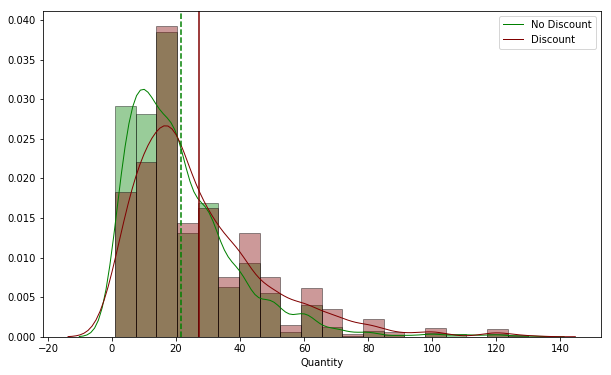

In [9]:
#plot density plot of two dataframes
#set fig size
plt.figure(figsize=(10,6))
#seaborn distribution plot with arguments
sns.distplot(q1Anodis['Quantity'], hist=True, kde=True, 
             bins=int(20), color = 'green', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1, 'label': 'No Discount'})
#seaborn distribution plot with arguments
sns.distplot(q1Adis['Quantity'], hist=True, kde=True, 
             bins=int(20), color = 'maroon', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1, 'label': 'Discount'})
#set both mean lines
plt.axvline(x=q1Anodis['Quantity'].mean(), color='green', linestyle='--')
plt.axvline(x=q1Adis['Quantity'].mean(), color='maroon', linestyle='-')
#save figure as png
plt.savefig('DiscountDensity.png')

In [10]:
q1A.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

It is apparent that discount levels from 0.01-0.06, excluding 0.05, are rarely offered by employees. Therefore, we will group the discount levels that are 0.06 or less. Then, to conduct the one-way ANOVA test, we assign boolean values in new columns if discount applied on order is equal to that value.

In [11]:
#drop all rows that don't have a discount
q1B = q1A.loc[q1A['Discount'] != 0]
q1B = q1B.reset_index(drop=True)

#for loop creating new columns with False entries
newc = ['Discountlow', 'Discount10', 'Discount15', 'Discount20', 'Discount25']
for x in newc:
    q1B[x] = False

#for loop running through database and assign boolean value in new column if discount is applied on order
for idx, x in enumerate(q1B.Discount):
    if 0 < x <= 0.06:
        q1B.loc[idx, 'Discountlow'] = True
    elif x == 0.10:
        q1B.loc[idx, 'Discount10'] = True
    elif x == 0.15:
        q1B.loc[idx, 'Discount15'] = True
    elif x == 0.20:
        q1B.loc[idx, 'Discount20'] = True
    elif x == 0.25:
        q1B.loc[idx, 'Discount25'] = True
#see value counts and basic statistics to determine if there are outliers i Quantity
display(q1B.Quantity.value_counts())
q1B.Quantity.describe()

20     98
30     72
15     69
40     53
10     51
25     36
50     35
12     35
35     29
60     28
6      25
18     23
24     22
2      22
8      21
21     20
70     18
4      16
5      14
16     14
36     12
3      12
42     11
28     11
80     10
14      8
9       8
7       6
100     6
55      5
65      5
45      5
120     5
1       4
49      4
90      3
11      2
32      2
13      2
27      2
44      2
48      2
56      2
77      2
84      2
33      1
54      1
66      1
130     1
Name: Quantity, dtype: int64

count    838.000000
mean      27.109785
std       20.771439
min        1.000000
25%       12.000000
50%       20.000000
75%       36.000000
max      130.000000
Name: Quantity, dtype: float64

I will eliminate outliers in quantity by dropping all orders with less than 3 units in the order.

In [12]:
#map count of each unique Quantity to each row
z = q1B['Quantity'].value_counts()
z1 = z.to_dict()
q1B['Count'] = q1B['Quantity'].map(z1)
#for loop going through count column and dropping any rows
#that have count less than 4 except for quantity 1 to get rid of outliers
for idx, x in enumerate(q1B.Count):
    if x < 4:
        if q1B.Quantity[idx] == 1:
            pass
        else:
            q1B.drop(index = idx, axis = 0, inplace=True)
q1B = q1B.reset_index(drop=True)
q1B.head()

,Quantity,Discount,is_Discount,Discountlow,Discount10,Discount15,Discount20,Discount25,Count
0,35,0.15,True,False,False,True,False,False,29
1,15,0.15,True,False,False,True,False,False,69
2,6,0.05,True,True,False,False,False,False,25
3,15,0.05,True,True,False,False,False,False,69
4,40,0.05,True,True,False,False,False,False,53


### At what level(s) of discount is there a statistically significant difference in quantity ordered?

$H_0$ (for each level): there is no significant difference in quantity ordered due to that specific discount level  
$H_\alpha$ (for each level): there is a significant difference in order quantity due to that specific discount level

In [13]:
#one-way ANOVA test
f = 'Quantity ~ C(Discountlow) + C(Discount10) + C(Discount15) + C(Discount20) + C(Discount25)'
lm = ols(f, q1B).fit()
table = sm.stats.anova_lm(lm, typ=2)
display(table)

,sum_sq,df,F,PR(>F)
C(Discountlow),3859.920738,1.0,9.776806,0.001831
C(Discount10),1048.339618,1.0,2.655343,0.103592
C(Discount15),4808.926912,1.0,12.180547,0.000509
C(Discount20),3710.582189,1.0,9.398546,0.002244
C(Discount25),7210.642740,1.0,18.263861,0.000022
Residual,319001.510225,808.0,NaN,NaN


group1,group2,meandiff,lower,upper,reject
0.0,0.05,5.207,1.0635,9.3506,True
0.0,0.1,3.5217,-0.8257,7.8692,False
0.0,0.15,6.6669,2.1279,11.2059,True
0.0,0.2,5.3096,0.8212,9.7979,True
0.0,0.25,6.525,1.9467,11.1033,True
0.05,0.1,-1.6853,-7.3138,3.9432,False
0.05,0.15,1.4599,-4.3179,7.2377,False
0.05,0.2,0.1026,-5.6355,5.8406,False
0.05,0.25,1.318,-4.4907,7.1267,False
0.1,0.15,3.1452,-2.7805,9.0709,False


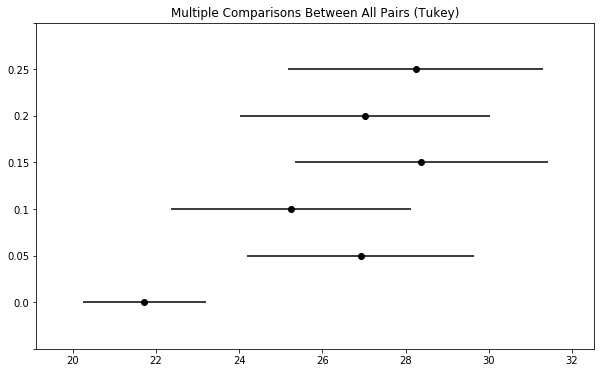

In [14]:
#for loop on original dataframe making all low discount levels equal to 0.05 to perform tukey test
for idx, x in enumerate(q1A.Discount):
    if 0.00 < x <= 0.06:
        q1A.loc[idx, 'Discount'] = 0.05
    else:
        pass
#conduct pairwise tukey test
tukey_results = pairwise_tukeyhsd(q1A['Quantity'], q1A['Discount'])
display(tukey_results.summary())
tukey_results.plot_simultaneous().show()

In [15]:
#make new seperate dataframes to calculate Cohen's d statistic
q1A0 = q1A.loc[q1A['Discount'] == 0]
q1A5 = q1A.loc[q1A['Discount'] == 0.05]
q1A10 = q1A.loc[q1A['Discount'] == 0.10]
q1A15 = q1A.loc[q1A['Discount'] == 0.15]
q1A20 = q1A.loc[q1A['Discount'] == 0.20]
q1A25 = q1A.loc[q1A['Discount'] == 0.25]
#for loop to drop columns
for x in [q1A0, q1A5, q1A10, q1A15, q1A20, q1A25]:
    x.drop(['is_Discount'], axis=1, inplace = True)
    x.drop(['Discount'], axis=1, inplace = True)
#for loop to print Cohen's d statistic
for x in [q1A5, q1A15, q1A20, q1A25]:
    print(cohens_d(q1A0, x))

Quantity    0.286135
dtype: float64
Quantity    0.372404
dtype: float64
Quantity    0.300712
dtype: float64
Quantity    0.366593
dtype: float64


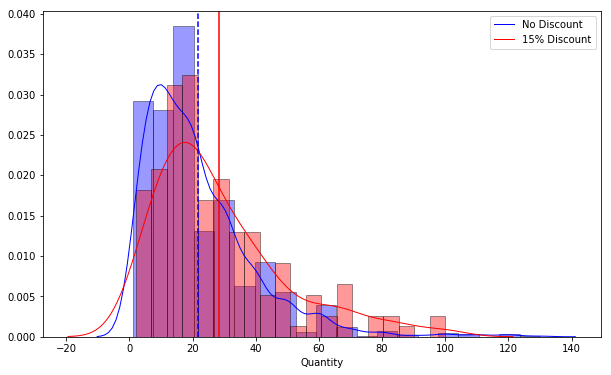

In [16]:
#set fig size
plt.figure(figsize=(10,6))
#seaborn distribution plot with arguments
sns.distplot(q1A0['Quantity'], hist=True, kde=True, 
             bins=int(20), color = 'blue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1, 'label': 'No Discount'})
#seaborn distribution plot with arguments
sns.distplot(q1A15['Quantity'], hist=True, kde=True, 
             bins=int(20), color = 'red', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1, 'label': '15% Discount'})
#plot both mean lines
plt.axvline(x=q1A0['Quantity'].mean(), color='blue', linestyle='--')
plt.axvline(x=q1A15['Quantity'].mean(), color='red', linestyle='-')
#save fig as png
plt.savefig('15DiscountDensity.png')

We see that we may reject our null hypothesis that there is no significant difference in quantity ordered due to these specific discount being applied to the order except for discount level 10%. From our Tukey test, we can conclude that the means of groups with discount levels 0.05, 0.15, 0.20 and 0.25 differ from the mean of the group without discounts, except for the 10% level.

Let's take a look at our difference in mean and effect size of our significant levels of discount:  
1%-6% - difference in mean: 5.21, effect size: 0.29  
15% - difference in mean: 6.67, effect size: 0.37  
20% - difference in mean: 5.31, effect size: 0.30  
25% - difference in mean: 6.53, effect size: 0.37
      
Most of our difference in means and effect sizes are relatively the same. We also see that 15% discount has the largest difference in mean and largest effect size. Therefore, I would suggest not offer discount levels above 15%.

## Question 2
### Is there a statistically significant difference in the level(s) of discount offered by UK employees and USA employees?

$H_0$: there is no significant difference in level(s) of discount offered by the two countries  
$H_\alpha$: there is a significant difference in level(s) of discount offered by the two countries

In [17]:
#SQL query selecting quantity ordered and discount
x = """SELECT od.Quantity, od.Discount, e.Country
       FROM OrderDetail AS od
       JOIN [Order] ON od.OrderId = [Order].Id
       JOIN Employee AS e ON [Order].EmployeeId = e.Id
       ;"""
q2 = pd.read_sql_query(x, conn)
q2.head()

,Quantity,Discount,Country
0,12,0.0,UK
1,10,0.0,UK
2,5,0.0,UK
3,9,0.0,UK
4,40,0.0,UK


In [18]:
#groupby function to see average values by Country
q2.groupby('Country').mean()

,Quantity,Discount
Country,,
UK,24.448944,0.065493
USA,23.585381,0.052829


On average, both UK and USA employees sell similar quantities per order of about 24 units. The discounts offered both average around 0.05-0.06 as well.

In [19]:
#create Quantity pivot table
q2A = q2.drop('Quantity', axis = 1).pivot_table(index='Country', columns='Discount', aggfunc=len, fill_value=0, margins=True)
q2A

Discount,0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.1,0.15,0.2,0.25,All
Country,,,,,,,,,,,,
UK,309,0,0,0,0,55,0,60,53,45,46,568
USA,1008,1,2,3,1,130,1,113,104,116,108,1587
All,1317,1,2,3,1,185,1,173,157,161,154,2155


In [20]:
#for loop to calculate percentage of whole for each average quantity by discount level
for x in q2A.columns:
    #set the position in table with calculated value
    q2A.loc['UK', x] = round((float(q2A[x]['UK'])/float(q2A['All']['UK'])*100), 2)
    #set the position in table with calculated value
    q2A.loc['USA', x] = round((float(q2A[x]['USA'])/float(q2A['All']['USA'])*100), 2)
#drop last row and column
q2A.drop(['All'], axis = 1, inplace = True)
q2A.drop(['All'], axis = 0, inplace = True)
q2A

Discount,0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.1,0.15,0.2,0.25
Country,,,,,,,,,,,
UK,54.40,0.00,0.00,0.00,0.00,9.68,0.00,10.56,9.33,7.92,8.10
USA,63.52,0.06,0.13,0.19,0.06,8.19,0.06,7.12,6.55,7.31,6.81


Although both US and UK employees on average offer discount levels around 5-6%, US employees offer a number of low discount levels from 6% and below, whereas UK employees only offer 5%, 10%, 15%, 20% and 25% discounts.

In [21]:
#one-way ANOVA test
f = 'Discount ~ C(Country)'
lm = ols(f, q2).fit()
table = sm.stats.anova_lm(lm, typ=2)
display(table)

,sum_sq,df,F,PR(>F)
C(Country),0.067081,1.0,9.671415,0.001896
Residual,14.933259,2153.0,NaN,NaN


In [22]:
#pairwise tukey test
tukey_results = pairwise_tukeyhsd(q2['Discount'], q2['Country'])
display(tukey_results.summary())

group1,group2,meandiff,lower,upper,reject
UK,USA,-0.0127,-0.0206,-0.0047,True


In [23]:
#new dataframes where Country isn't specific value
q2USA = q2.loc[q2['Country'] == 'USA']
q2UK = q2.loc[q2['Country'] == 'UK']
#run Cohen's d function
print(cohens_d(q2USA['Discount'], q2UK['Discount']))

0.15205550318243274


We see that we may reject our null hypothesis that there is no significant difference in discount levels offered due to the country in which the employee resides. From our Tukey test, we can conclude that US employees do in fact offer discounts at lower prices than UK employees with a mean difference of 1.3%. However, we do have a small effect size of 0.15, suggesting the difference is simply trivial. Nonetheless, let us see if discount levels are significantly different when we take into account which country the discount is being offered from.

### Does the level(s) of discount offered by US employees have a statistically significant effect on the quantity ordered? If so, at what level(s) of discount?

$H_0$ (for each level): there is no significant difference in quantity ordered due to that specific discount level  
$H_\alpha$ (for each level): there is a significant difference in order quantity due to that specific discount level

In [24]:
#for loop creating new columns with False entries
for x in newc:
    q2[x] = False

#for loop running through database and assign boolean value in new column if discount is applied on order
for idx, x in enumerate(q2.Discount):
    if 0 < x <= 0.06:
        q2.loc[idx, 'Discountlow'] = True
    elif x == 0.10:
        q2.loc[idx, 'Discount10'] = True
    elif x == 0.15:
        q2.loc[idx, 'Discount15'] = True
    elif x == 0.20:
        q2.loc[idx, 'Discount20'] = True
    elif x == 0.25:
        q2.loc[idx, 'Discount25'] = True
q2.sample(10)

,Quantity,Discount,Country,Discountlow,Discount10,Discount15,Discount20,Discount25
1973,50,0.05,USA,True,False,False,False,False
146,12,0.00,USA,False,False,False,False,False
1162,40,0.00,USA,False,False,False,False,False
1573,45,0.20,USA,False,False,False,True,False
471,49,0.20,UK,False,False,False,True,False
392,70,0.10,UK,False,True,False,False,False
252,56,0.20,USA,False,False,False,True,False
2095,30,0.10,USA,False,True,False,False,False
1534,2,0.20,USA,False,False,False,True,False
1538,60,0.00,UK,False,False,False,False,False


In [25]:
#new dataframe by dropping all rows where Discount level is zero percent
q2B = q2.loc[q2['Discount'] != 0]
q2B = q2B.reset_index(drop=True)
q2B.head()

,Quantity,Discount,Country,Discountlow,Discount10,Discount15,Discount20,Discount25
0,35,0.15,USA,False,False,True,False,False
1,15,0.15,USA,False,False,True,False,False
2,6,0.05,USA,True,False,False,False,False
3,15,0.05,USA,True,False,False,False,False
4,40,0.05,USA,True,False,False,False,False


In [26]:
#map count of each unique Quantity to each row
z = q2B['Quantity'].value_counts()
z1 = z.to_dict()
q2B['Count'] = q2B['Quantity'].map(z1)
#for loop going through count column and dropping any rows
#that have count less than 4 except for quantity 1 to get rid of outliers
for idx, x in enumerate(q2B.Count):
    if x < 4:
        if q2B.Quantity[idx] == 1:
            pass
        else:
            q2B.drop(index = idx, axis = 0, inplace=True)
q2B = q2B.reset_index(drop=True)
q2B.head()

,Quantity,Discount,Country,Discountlow,Discount10,Discount15,Discount20,Discount25,Count
0,35,0.15,USA,False,False,True,False,False,29
1,15,0.15,USA,False,False,True,False,False,69
2,6,0.05,USA,True,False,False,False,False,25
3,15,0.05,USA,True,False,False,False,False,69
4,40,0.05,USA,True,False,False,False,False,53


In [27]:
#new dataframe including rows where country is USA
q2USA = q2B.loc[q2B['Country'] != 'UK']
q2USA = q2USA.reset_index(drop=True)
q2USA.head()

,Quantity,Discount,Country,Discountlow,Discount10,Discount15,Discount20,Discount25,Count
0,35,0.15,USA,False,False,True,False,False,29
1,15,0.15,USA,False,False,True,False,False,69
2,6,0.05,USA,True,False,False,False,False,25
3,15,0.05,USA,True,False,False,False,False,69
4,40,0.05,USA,True,False,False,False,False,53


In [28]:
#one-way ANOVA test
f = 'Quantity ~ C(Discountlow) + C(Discount10) + C(Discount15) + C(Discount20) + C(Discount25)'
lm = ols(f, q2USA).fit()
table = sm.stats.anova_lm(lm, typ=2)
display(table)

,sum_sq,df,F,PR(>F)
C(Discountlow),3068.541493,1.0,7.526524,0.006276
C(Discount10),1698.908746,1.0,4.167086,0.041687
C(Discount15),3675.837972,1.0,9.016101,0.002796
C(Discount20),2832.600694,1.0,6.947808,0.008626
C(Discount25),2184.416458,1.0,5.357940,0.020991
Residual,227087.259134,557.0,NaN,NaN


group1,group2,meandiff,lower,upper,reject
0.0,0.05,5.0762,0.2229,9.9295,True
0.0,0.1,4.3661,-0.9385,9.6706,False
0.0,0.15,7.6353,2.1282,13.1424,True
0.0,0.2,5.5299,0.2874,10.7724,True
0.0,0.25,4.329,-1.0848,9.7429,False
0.05,0.1,-0.7101,-7.4939,6.0737,False
0.05,0.15,2.5591,-4.3842,9.5024,False
0.05,0.2,0.4536,-6.2817,7.189,False
0.05,0.25,-0.7472,-7.6168,6.1224,False
0.1,0.15,3.2692,-3.9967,10.5351,False


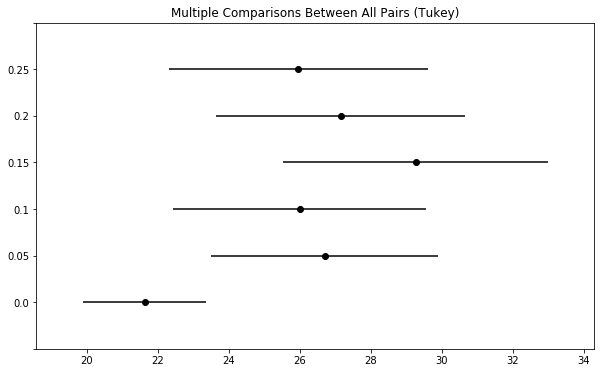

In [29]:
#new dataframe including rows where country is USA but including Discount level zero and changing all low levels to
#0.05 so we may run tukey test
q2C = q2.loc[q2['Country'] != 'UK']
q2C = q2C.reset_index(drop=True)
#for loop to change all values 0.01-0.06 to 0.05 in Discount column
for idx, x in enumerate(q2C.Discount):
    if 0.00 < x <= 0.06:
        q2C.loc[idx, 'Discount'] = 0.05
    else:
        pass
#pairwise tukey test
tukey_results = pairwise_tukeyhsd(q2C['Quantity'], q2C['Discount'])
display(tukey_results.summary())
tukey_results.plot_simultaneous().show()

In [30]:
#new dataframes where Discount is specific value
q20 = q2.loc[q2['Discount'] == 0]
q25 = q2.loc[q2['Discount'] == 0.05]
q215 = q2.loc[q2['Discount'] == 0.15]
q220 = q2.loc[q2['Discount'] == 0.20]
#for loop dropping all rows where Country isn't USA
for x in [q20, q25, q215, q220]:
    x = x.loc[x['Country'] != 'UK']
    x = x.reset_index(drop=True)
#for loop running cohen's d function
for x in [q25, q215, q220]:
    print(cohens_d(q20['Quantity'], x['Quantity']))

0.3468767736284544
0.3724041317472808
0.3007122542913553


Although in our ANOVA test, we have p-values for each level of discount lower than the alpha level, giving us indication to reject the null hypothesis for all levels, our Tukey Post-HOC HSD pairwise test, we conclude that only groups with discount levels of 1-6%, 15% and 20% have difference in means from the group with zero discount. Thus, it would be best for US employees to offer those levels to their customers in order to increase quantity.

Let's take a look at our difference in mean and effect size of our significant levels of discount:  
1%-6% - difference in mean: 5.07, effect size: 0.35  
15% - difference in mean: 7.64, effect size: 0.37  
20% - difference in mean: 5.53, effect size: 0.30  
      
We see that 15% discount has the largest difference in mean and largest effect size. Therefore, I would suggest not offer discount levels above 15%.

### Does the level(s) of discount offered by UK employees have a statistically significant effect on the quantity ordered? If so, at what level(s) of discount?

$H_0$ (for each level): there is no significant difference in quantity ordered due to that specific discount level  
$H_\alpha$ (for each level): there is a significant difference in order quantity due to that specific discount level

In [31]:
#new dataframe where Country isn't USA
q2UK = q2B.loc[q2B['Country'] != 'USA']
q2UK = q2UK.reset_index(drop=True)
q2UK.head()

,Quantity,Discount,Country,Discountlow,Discount10,Discount15,Discount20,Discount25,Count
0,15,0.15,UK,False,False,True,False,False,69
1,21,0.15,UK,False,False,True,False,False,20
2,60,0.25,UK,False,False,False,False,True,28
3,60,0.25,UK,False,False,False,False,True,28
4,36,0.25,UK,False,False,False,False,True,12


In [32]:
#one-way ANOVA test
f = 'Quantity ~ C(Discountlow) + C(Discount10) + C(Discount15) + C(Discount20) + C(Discount25)'
lm = ols(f, q2UK).fit()
table = sm.stats.anova_lm(lm, typ=2)
display(table)

,sum_sq,df,F,PR(>F)
C(Discountlow),759.507299,1.0,2.083938,0.150128
C(Discount10),7.170052,1.0,0.019673,0.888568
C(Discount15),1096.591752,1.0,3.008831,0.084065
C(Discount20),831.541590,1.0,2.281586,0.132201
C(Discount25),6964.440564,1.0,19.109051,0.000018
Residual,89656.592439,246.0,NaN,NaN


group1,group2,meandiff,lower,upper,reject
0.0,0.05,5.474,-2.5343,13.4823,False
0.0,0.1,1.8194,-5.9004,9.5393,False
0.0,0.15,4.6609,-3.4746,12.7965,False
0.0,0.2,4.6861,-4.045,13.4171,False
0.0,0.25,11.6064,2.9586,20.2542,True
0.05,0.1,-3.6545,-13.8696,6.5605,False
0.05,0.15,-0.813,-11.3458,9.7197,False
0.05,0.2,-0.7879,-11.7871,10.2113,False
0.05,0.25,6.1324,-4.8009,17.0657,False
0.1,0.15,2.8415,-7.4736,13.1567,False


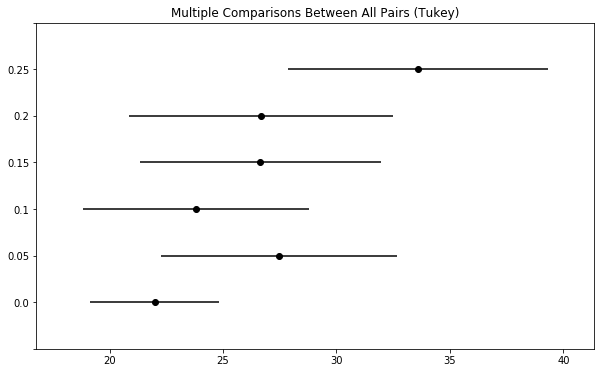

In [33]:
#new dataframe where rows have Country equal to UK
q2D = q2.loc[q2['Country'] != 'USA']
q2D = q2D.reset_index(drop=True)
#for loop to change all values 0.01-0.06 to 0.05 in Discount column
for idx, x in enumerate(q2D.Discount):
    if 0.00 < x <= 0.06:
        q2D.loc[idx, 'Discount'] = 0.05
    else:
        pass
#pairwise tukey test
tukey_results = pairwise_tukeyhsd(q2D['Quantity'], q2D['Discount'])
display(tukey_results.summary())
tukey_results.plot_simultaneous().show()

In [34]:
#new dataframes where Discount is specific value only
q20 = q2.loc[q2['Discount'] == 0]
q225 = q2.loc[q2['Discount'] == 0.25]
#for loop dropping all rows where Country is USA
for x in [q20, q225]:
    x = x.loc[x['Country'] != 'USA']
    x = x.reset_index(drop=True)
#run cohen's d function
print(cohens_d(q20['Quantity'], q225['Quantity']))

0.36659255652674416


Both our ANOVA test and Tukey Post-HOC HSD pairwise test give us the conclusion that we may reject the null hypothesis for discount level of 25%, meaning quantity is significantly greater when discount level offered is 25%. Thus, offering 25% would be best for UK employees to increase quantity ordered. We also have an effect size of 0.37, which shows strong relationship between Quantity and the 25% level compared to the other levels shown before.

## Question 3

### This question will circulate around the signficance of the age and title of the employee processing the order

### Does the age of the employee have a statistically significant effect on number of orders processed?

$H_0$: there is no significant difference in total sum of orders processed due employee age  
$H_\alpha$: there is a significant difference in total sum of orders processed due to employee age

In [35]:
#SQL query selecting quantity ordered and discount
x = """SELECT o.Id, e.BirthDate, e.Title
       FROM [Order] AS o
       JOIN Employee AS e ON o.EmployeeId = e.Id
       ;"""
q3 = pd.read_sql_query(x, conn)
display(q3.sample(10))
q3.BirthDate.unique()

,Id,BirthDate,Title
650,10898,1969-09-19,Sales Representative
711,10959,1995-07-02,Sales Representative
792,11040,1969-09-19,Sales Representative
506,10754,1995-07-02,Sales Representative
720,10968,1980-12-08,Sales Representative
713,10961,1990-01-09,Inside Sales Coordinator
383,10631,1990-01-09,Inside Sales Coordinator
508,10756,1990-01-09,Inside Sales Coordinator
359,10607,1987-03-04,Sales Manager
679,10927,1969-09-19,Sales Representative


array(['1987-03-04', '1995-07-02', '1969-09-19', '1995-08-30',
       '1998-01-27', '1980-12-08', '1990-01-09', '1984-02-19',
       '1992-05-29'], dtype=object)

In [36]:
#for loop slicing BirthDate column values
for idx, x in enumerate(q3.BirthDate):
    q3.loc[idx, 'BirthDate'] = q3.iloc[idx]['BirthDate'][0:4]
q3.sample(5)

,Id,BirthDate,Title
65,10313,1984,"Vice President, Sales"
423,10671,1980,Sales Representative
785,11033,1992,Sales Representative
674,10922,1987,Sales Manager
292,10540,1995,Sales Representative


In [37]:
newc = ['1969', '1980', '1984', '1987', '1990', '1992', '1995', '1998']
count = 0
x = []
#while loop with nested for loop to count number of orders received by employees born in each year in the list above
while count <= (len(newc)-1):
    for idx, ele in enumerate(q3.BirthDate):
        if ele == newc[count]:
            x.append(q3.iloc[idx]['Title'])
            count += 1
            break
        else:
            pass

In [38]:
#creating series to later put in dictionary
z = q3.groupby('BirthDate').count()['Id'].reset_index(drop=True)
x = pd.Series(x)
y = pd.Series(q3.groupby('BirthDate').count().index)

In [39]:
#creating new dataframe using pd.DataFrame
dic = { 'Count': z, 'Birthdate': y, 'Title': x} 
q3 = pd.DataFrame(dic)
q3

,Count,Birthdate,Title
0,156,1969,Sales Representative
1,123,1980,Sales Representative
2,96,1984,"Vice President, Sales"
3,42,1987,Sales Manager
4,104,1990,Inside Sales Coordinator
5,72,1992,Sales Representative
6,194,1995,Sales Representative
7,43,1998,Sales Representative


We know that there are 9 employees in Northwind Traders, where two employees are born in 1995 and their title's are the same. Therefore, it makes sense that 1995 has the most orders received. However, we can see that the employee born before the 70s has the second highest and then the rest are relatively close to each other. Although, most of highest counts look to be from older employees.

,sum_sq,df,F,PR(>F)
C(Decade),3572.75,2.0,0.549831,0.60836
Residual,16244.75,5.0,NaN,NaN


group1,group2,meandiff,lower,upper,reject
60.0,80.0,-69.0,-282.9034,144.9034,False
60.0,90.0,-52.75,-259.8611,154.3611,False
80.0,90.0,16.25,-125.2338,157.7338,False


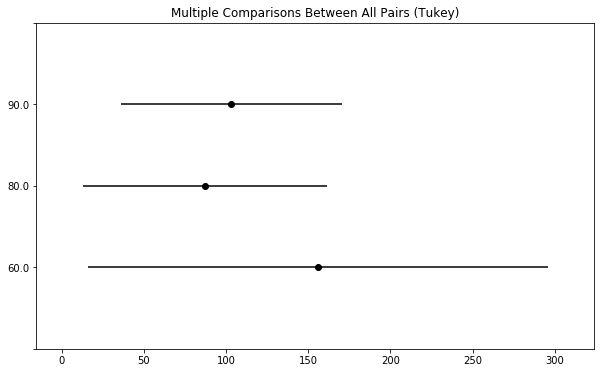

In [40]:
q3.Birthdate = q3.Birthdate.astype(int)
#for loop replacing Birthdate column with int value if it falls within certain range
for idx, x in enumerate(q3.Birthdate):
    if x < 1970:
        q3.loc[idx, 'Decade'] = 60
    if 1970 <= x < 1990:
        q3.loc[idx, 'Decade'] = 80
    if 1990 <= x:
        q3.loc[idx, 'Decade'] = 90
#one-way ANOVA test
f = 'Count ~ C(Decade)'
lm = ols(f, q3).fit()
table = sm.stats.anova_lm(lm, typ=2)
display(table)
#pairwise tukey test
tukey_results = pairwise_tukeyhsd(q3['Count'], q3['Decade'])
display(tukey_results.summary())
tukey_results.plot_simultaneous().show()

From both our ANOVA test and Tukey test, we cannot reject the null hypothesis that the different decades significantly affect the number of orders received. Therefore, we cannot confirm that there is a significant difference in order count due to age of employee.

### Does having a managerial position in Northwind have a statistically significant effect on number of orders recieved?

$H_0$: there is no significant difference in total sum of orders processed due to the employee receiving order having a managerial position  
$H_\alpha$: there is a significant difference in total sum of orders processed due to the employee receiving order having a managerial position

In [41]:
#for loop looping through Title column and creating new boolean column
for idx, x in enumerate(q3.Title):
    if 'Manager' in x or 'President' in x:
        q3.loc[idx, 'Management'] = True
    else:
        q3.loc[idx, 'Management'] = False
#one-way ANOVA test
f = 'Count ~ C(Management)'
lm = ols(f, q3).fit()
table = sm.stats.anova_lm(lm, typ=2)
display(table)
#pairwise tukey test
tukey_results = pairwise_tukeyhsd(q3['Count'], q3['Management'])
display(tukey_results.summary())

,sum_sq,df,F,PR(>F)
C(Management),3220.166667,1.0,1.164103,0.322068
Residual,16597.333333,6.0,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-46.3333,-151.4124,58.7457,False


Similarly to age, from both our ANOVA test and Tukey test, we cannot reject the null hypothesis that having a managerial position in Northwind has a significant effect on order count.

### Does the age of the employee have a statistically significant effect on the quantity of a product in an order?

$H_0$: there is no significant difference in quantity ordered due employee age  
$H_\alpha$: there is a significant difference in order quantity ordered due to employee age

In [42]:
#SQL query selecting quantity ordered and discount
x = """SELECT od.Quantity, e.BirthDate, e.Title, c.ContactTitle
       FROM OrderDetail AS od
       JOIN [Order] AS o ON od.OrderId = o.Id
       JOIN Employee AS e ON o.EmployeeId = e.Id
       JOIN Customer AS c ON o.CustomerId = c.Id
       ;"""
q3 = pd.read_sql_query(x, conn)
q3.sample(10)
#for loop slicing Birthdate column values
for idx, x in enumerate(q3.BirthDate):
    q3.loc[idx, 'BirthDate'] = q3.iloc[idx]['BirthDate'][0:4]
q3.sample(5)

,Quantity,BirthDate,Title,ContactTitle
749,9,1980,Sales Representative,Sales Manager
896,24,1990,Inside Sales Coordinator,Owner
891,30,1995,Sales Representative,Sales Representative
480,12,1990,Inside Sales Coordinator,Sales Representative
1549,4,1984,"Vice President, Sales",Sales Representative


,sum_sq,df,F,PR(>F)
C(BirthDate),4290.687970,7.0,1.67501,0.110648
Residual,757498.450144,2070.0,NaN,NaN


group1,group2,meandiff,lower,upper,reject
1969,1980,-0.7209,-4.9793,3.5376,False
1969,1984,1.7812,-2.959,6.5214,False
1969,1987,1.9355,-4.2342,8.1053,False
1969,1990,-0.8272,-5.5004,3.846,False
1969,1992,4.4196,-1.1223,9.9615,False
1969,1995,-0.185,-4.1046,3.7345,False
1969,1998,1.4729,-4.8309,7.7766,False
1980,1984,2.5021,-2.4062,7.4104,False
1980,1987,2.6564,-3.6434,8.9562,False
1980,1990,-0.1063,-4.95,4.7373,False


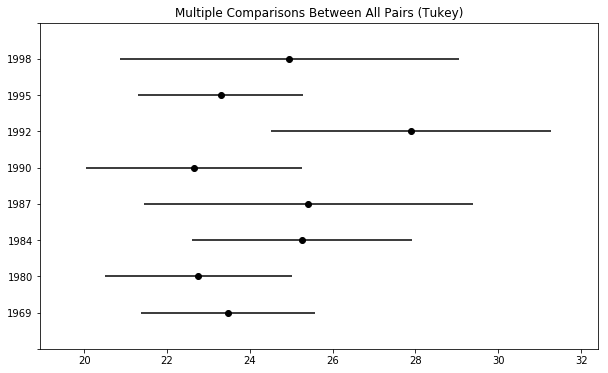

In [43]:
#one-way ANOVA test
f = 'Quantity ~ C(BirthDate)'
lm = ols(f, q3).fit()
table = sm.stats.anova_lm(lm, typ=2)
display(table)
#pairwise tukey test
tukey_results = pairwise_tukeyhsd(q3['Quantity'], q3['BirthDate'])
display(tukey_results.summary())
tukey_results.plot_simultaneous().show()

From both our ANOVA test and Tukey test, we cannot reject the null hypothesis that age of employee has a significant effect on quantity ordered.

### Does having manager in your title have a statistically significant effect on quantity ordered by the customer?

$H_0$: there is no significant difference in quantity ordered due to the employee making order having a managerial position  
$H_\alpha$: there is a significant difference in order quantity ordered due to the employee making order having a managerial position

In [44]:
#for loop looping through ContactTitle column and creating new boolean column
for idx, x in enumerate(q3.ContactTitle):
    if 'Manager' in x:
        q3.loc[idx, 'Manager'] = True
    else:
        q3.loc[idx, 'Manager'] = False
#one-way ANOVA test
f = 'Quantity ~ C(Manager)'
lm = ols(f, q3).fit()
table = sm.stats.anova_lm(lm, typ=2)
display(table)
#pairwise tukey test
tukey_results = pairwise_tukeyhsd(q3['Quantity'], q3['Manager'])
display(tukey_results.summary())

,sum_sq,df,F,PR(>F)
C(Manager),9585.082472,1.0,26.453768,2.952829e-07
Residual,752204.055641,2076.0,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,4.3781,2.7088,6.0475,True


In [45]:
#new dataframes where Manager is specific value
q3man = q3.loc[q3['Manager'] == True]
q3noman = q3.loc[q3['Manager'] == False]
#run cohen's d function
print(cohens_d(q3man['Quantity'], q3noman['Quantity']))

0.2299990158917602


We conclude that we may reject our null hypothesis that a customer whose title is manager has no significant effect on quantity ordered. From our Tukey test, we find a difference of 4.38 more units ordered for customers in a managerial position. Our effect size is also at 0.23, letting us know the difference in mean is not trivial.

## Question 4
### For each category type of product, does the season in which the order was placed have a statistically significant effect on the quantity of a product in an order?

$H_0$: there is no significant difference in quantity ordered due to season in which order was placed  
$H_\alpha$: there is a significant difference in order quantity ordered due to season in which order was placed

In [74]:
#SQL query selecting quantity ordered and discount
x = """SELECT [Order].OrderDate, ca.CategoryName, ca.Id, od.Quantity
       FROM OrderDetail AS od
       JOIN [Order] ON od.OrderId = [Order].Id
       JOIN Product AS p ON od.ProductId = p.Id
       JOIN Customer AS c ON c.Id = [Order].CustomerId
       JOIN Category AS ca ON p.CategoryId = ca.Id
       ;"""
q4 = pd.read_sql_query(x, conn)
display(q4.head())
#groupby function by Category name
q4.groupby('CategoryName').mean()

,OrderDate,CategoryName,Id,Quantity
0,2012-07-04,Dairy Products,4,12
1,2012-07-04,Grains/Cereals,5,10
2,2012-07-04,Dairy Products,4,5
3,2012-07-05,Produce,7,9
4,2012-07-05,Produce,7,40


,Id,Quantity
CategoryName,,
Beverages,1.0,23.421594
Condiments,2.0,24.712919
Confections,3.0,23.800623
Dairy Products,4.0,25.017143
Grains/Cereals,5.0,23.452632
Meat/Poultry,6.0,24.434524
Produce,7.0,22.136364
Seafood,8.0,23.699060


Dairy Products have the highest average quantity ordered per order, whereas Produce has the lowest average quantity ordered per order. However, the difference between the two is 2 units. Almost every type of category is roughly 23-24 units per order.

In [75]:
q4.OrderDate = pd.to_datetime(q4.OrderDate)
#create dictionary for seasons
season_names = {1: 'Winter', 2 : 'Spring', 3: 'Summer', 4: 'Fall'}
#using modular arithmetic, we split the year into 4 3-month sections and convert each
#month for each row to a number between 1-4
season = q4.OrderDate.apply(lambda dt: (dt.month%12 + 3)//3)
#map to our dictionary
q4['season'] = season.map(season_names)
#for loop creating new columns with boolean values for specific seasons\
for idx, x in enumerate(q4.season):
    q4.loc[idx, 'Winter'] = True if x == 'Winter' else False
    q4.loc[idx, 'Spring'] = True if x == 'Spring' else False
    q4.loc[idx, 'Summer'] = True if x == 'Summer' else False
    q4.loc[idx, 'Fall'] = True if x == 'Fall' else False
q4.sample(10)

,OrderDate,CategoryName,Id,Quantity,season,Winter,Spring,Summer,Fall
370,2012-12-20,Beverages,1,30,Winter,True,False,False,False
975,2013-08-12,Beverages,1,25,Summer,False,False,True,False
1268,2013-11-20,Seafood,8,40,Fall,False,False,False,True
47,2012-07-24,Beverages,1,35,Summer,False,False,True,False
838,2013-06-17,Produce,7,11,Summer,False,False,True,False
135,2012-09-05,Seafood,8,40,Fall,False,False,False,True
1805,2014-03-25,Condiments,2,16,Spring,False,True,False,False
358,2012-12-18,Beverages,1,15,Winter,True,False,False,False
2036,2014-05-05,Confections,3,30,Spring,False,True,False,False
365,2012-12-19,Grains/Cereals,5,20,Winter,True,False,False,False


In [80]:
#map countof Quantity column to each quantity value
z = q4['Quantity'].value_counts()
z1 = z.to_dict()
q4['Count'] = q4['Quantity'].map(z1)
#for loop looping through Count column and dropping all rows where count is less than 4
#except when quantity equals 1
for idx, x in enumerate(q4.Count):
    if x < 4:
        if q4.Quantity[idx] == 1:
            pass
        else:
            q4.drop(index = idx, axis = 0, inplace=True)
q4 = q4.reset_index(drop=True)
q4.sample(10)

,OrderDate,CategoryName,Id,Quantity,season,Winter,Spring,Summer,Fall,Count
1270,2013-11-25,Seafood,8,3,Fall,False,False,False,True,45
185,2012-10-02,Produce,7,14,Fall,False,False,False,True,35
494,2013-02-11,Condiments,2,60,Winter,True,False,False,False,56
1285,2013-11-28,Beverages,1,40,Fall,False,False,False,True,109
754,2013-05-20,Dairy Products,4,15,Spring,False,True,False,False,159
1512,2014-01-26,Beverages,1,5,Winter,True,False,False,False,62
931,2013-07-31,Grains/Cereals,5,14,Summer,False,False,True,False,35
1809,2014-03-30,Confections,3,36,Spring,False,True,False,False,20
1369,2013-12-26,Confections,3,2,Winter,True,False,False,False,50
871,2013-07-07,Condiments,2,14,Summer,False,False,True,False,35


In [82]:
f = 'Quantity ~ C(Id)*C(season)'
lm = ols(f, q4).fit()
table = sm.stats.anova_lm(lm, typ=1)
display(table)

,df,sum_sq,mean_sq,F,PR(>F)
C(Id),7.0,1107.521247,158.217321,0.471976,0.855405
C(season),3.0,1976.178716,658.726239,1.965039,0.117190
C(Id):C(season),21.0,8051.361837,383.398183,1.143711,0.293627
Residual,2016.0,675809.640837,335.223036,NaN,NaN


In [49]:
newc = ['Dairy Products', 'Grains/Cereals', 'Produce', 'Seafood',
       'Condiments', 'Confections', 'Beverages', 'Meat/Poultry']
#for loop looping through newc list above, with nested for loop inside
for x in newc:
    print(x)
    #new dataframe where CategoryName is only specific value, dropping all other rows
    q4A = q4.loc[q4['CategoryName'] == x]
    q4A = q4A.reset_index(drop=True)
    
    for y in q4A.columns[4:8]:
        print(y + ':')
        #one-way ANOVA test
        f = 'Quantity ~ C(' + y + ')'
        lm = ols(f, q4A).fit()
        table = sm.stats.anova_lm(lm, typ=1)
        display(table)
        print()
        #pairwise tukey test
        tukey_results = pairwise_tukeyhsd(q4A['Quantity'], q4A[y])
        display(tukey_results.summary())
        print()
        #new dataframes to run cohen's d function
        q4B1 = q4A.loc[q4A[y] == True]
        q4B2 = q4A.loc[q4A[y] == False] 
        print(cohens_d(q4B1['Quantity'], q4B2['Quantity']))
        print()

print('Total')
#for loop looping through columns 4 to 7
for y in q4.columns[4:8]:
    print(y + ':')
    #one-way ANOVA test
    f = 'Quantity ~ C(' + y + ')'
    lm = ols(f, q4).fit()
    table = sm.stats.anova_lm(lm, typ=1)
    display(table)
    print()
    #pairwise tukey test
    tukey_results = pairwise_tukeyhsd(q4['Quantity'], q4[y])
    display(tukey_results.summary())
    print()
    #new dataframes to run cohen's d function
    q41 = q4.loc[q4[y] == True]
    q42 = q4.loc[q4[y] == False]
    print(cohens_d(q41['Quantity'], q42['Quantity']))
    print()

Dairy Products
Winter:


,df,sum_sq,mean_sq,F,PR(>F)
C(Winter),1.0,1704.421018,1704.421018,5.330455,0.021546
Residual,345.0,110314.270625,319.751509,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,4.9869,0.7385,9.2352,True



0.2788472793368879

Spring:


,df,sum_sq,mean_sq,F,PR(>F)
C(Spring),1.0,1102.695478,1102.695478,3.429892,0.06488
Residual,345.0,110915.996165,321.495641,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-3.8502,-7.9392,0.2388,False



0.21475530582908853

Summer:


,df,sum_sq,mean_sq,F,PR(>F)
C(Summer),1.0,3.894425,3.894425,0.011995,0.912854
Residual,345.0,112014.797218,324.680572,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-0.2715,-5.1478,4.6047,False



0.01507156324628297

Fall:


,df,sum_sq,mean_sq,F,PR(>F)
C(Fall),1.0,27.358309,27.358309,0.08428,0.771754
Residual,345.0,111991.333333,324.612560,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-0.6667,-5.1834,3.85,False



0.03699673612408566

Grains/Cereals
Winter:


,df,sum_sq,mean_sq,F,PR(>F)
C(Winter),1.0,230.122440,230.122440,0.856388,0.355951
Residual,186.0,49980.579687,268.712794,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,2.3734,-2.6863,7.4331,False



0.1448068027605328

Spring:


,df,sum_sq,mean_sq,F,PR(>F)
C(Spring),1.0,358.550990,358.550990,1.337765,0.248912
Residual,186.0,49852.151138,268.022318,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-3.1061,-8.4039,2.1918,False



0.18977038848637284

Summer:


,df,sum_sq,mean_sq,F,PR(>F)
C(Summer),1.0,19.067328,19.067328,0.07066,0.790673
Residual,186.0,50191.634800,269.847499,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,0.8371,-5.3758,7.0501,False



0.05086646294435605

Fall:


,df,sum_sq,mean_sq,F,PR(>F)
C(Fall),1.0,0.548087,0.548087,0.00203,0.964108
Residual,186.0,50210.154040,269.947065,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-0.1275,-5.7109,5.4558,False



0.007766729138440475

Produce
Winter:


,df,sum_sq,mean_sq,F,PR(>F)
C(Winter),1.0,82.801055,82.801055,0.236016,0.627929
Residual,128.0,44906.091253,350.828838,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-1.7687,-8.9723,5.4349,False



0.09438676141238965

Spring:


,df,sum_sq,mean_sq,F,PR(>F)
C(Spring),1.0,110.989869,110.989869,0.316563,0.574664
Residual,128.0,44877.902439,350.608613,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,1.9146,-4.8187,8.6479,False



0.10225099850379749

Summer:


,df,sum_sq,mean_sq,F,PR(>F)
C(Summer),1.0,27.275079,27.275079,0.077649,0.780959
Residual,128.0,44961.617229,351.262635,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-1.2003,-9.7236,7.3229,False



0.06413859917145356

Fall:


,df,sum_sq,mean_sq,F,PR(>F)
C(Fall),1.0,7.323284,7.323284,0.020839,0.885445
Residual,128.0,44981.569024,351.418508,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,0.633,-8.0433,9.3093,False



0.03374102993667081

Seafood
Winter:


,df,sum_sq,mean_sq,F,PR(>F)
C(Winter),1.0,151.710950,151.710950,0.475746,0.490873
Residual,309.0,98537.118632,318.890352,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,1.579,-2.9255,6.0835,False



0.08841713696358584

Spring:


,df,sum_sq,mean_sq,F,PR(>F)
C(Spring),1.0,1686.043734,1686.043734,5.370851,0.021129
Residual,309.0,97002.785848,313.924873,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-4.9473,-9.1477,-0.7468,True



0.27925611574824755

Summer:


,df,sum_sq,mean_sq,F,PR(>F)
C(Summer),1.0,326.441048,326.441048,1.025496,0.312011
Residual,309.0,98362.388534,318.324882,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,2.8121,-2.652,8.2762,False



0.1575981536974712

Fall:


,df,sum_sq,mean_sq,F,PR(>F)
C(Fall),1.0,288.157634,288.157634,0.904879,0.34222
Residual,309.0,98400.671948,318.448777,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,2.24,-2.3935,6.8736,False



0.12551761546863882

Condiments
Winter:


,df,sum_sq,mean_sq,F,PR(>F)
C(Winter),1.0,1862.551862,1862.551862,4.970244,0.026877
Residual,204.0,76447.064643,374.740513,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,6.9669,0.8054,13.1283,True



0.3597657294474283

Spring:


,df,sum_sq,mean_sq,F,PR(>F)
C(Spring),1.0,1568.734782,1568.734782,4.170162,0.042429
Residual,204.0,76740.881723,376.180793,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-5.8263,-11.4516,-0.201,True



0.3005246238768775

Summer:


,df,sum_sq,mean_sq,F,PR(>F)
C(Summer),1.0,20.482106,20.482106,0.053371,0.81753
Residual,204.0,78289.134398,383.770267,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-0.813,-7.7513,6.1254,False



0.04147938091779327

Fall:


,df,sum_sq,mean_sq,F,PR(>F)
C(Fall),1.0,20.247577,20.247577,0.052759,0.818559
Residual,204.0,78289.368928,383.771416,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,0.7471,-5.6658,7.16,False



0.03813160483555205

Confections
Winter:


,df,sum_sq,mean_sq,F,PR(>F)
C(Winter),1.0,3.787730,3.787730,0.012578,0.910776
Residual,315.0,94861.114478,301.146395,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,0.2306,-3.8156,4.2769,False



0.013292421606621625

Spring:


,df,sum_sq,mean_sq,F,PR(>F)
C(Spring),1.0,702.755681,702.755681,2.350924,0.126212
Residual,315.0,94162.146527,298.927449,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,3.3366,-0.945,7.6183,False



0.1929155000873947

Summer:


,df,sum_sq,mean_sq,F,PR(>F)
C(Summer),1.0,122.602129,122.602129,0.407629,0.52364
Residual,315.0,94742.300079,300.769207,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-1.75,-7.1431,3.643,False



0.10092931613418578

Fall:


,df,sum_sq,mean_sq,F,PR(>F)
C(Fall),1.0,430.422208,430.422208,1.435736,0.231731
Residual,315.0,94434.480000,299.792000,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-2.7418,-7.244,1.7603,False



0.15836749211803972

Beverages
Winter:


,df,sum_sq,mean_sq,F,PR(>F)
C(Winter),1.0,117.659050,117.659050,0.360372,0.548655
Residual,382.0,124720.275846,326.492869,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-1.2244,-5.2345,2.7858,False



0.06775619447393243

Spring:


,df,sum_sq,mean_sq,F,PR(>F)
C(Spring),1.0,829.403813,829.403813,2.554923,0.110778
Residual,382.0,124008.531082,324.629663,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,3.1238,-0.7188,6.9663,False



0.1733487032859829

Summer:


,df,sum_sq,mean_sq,F,PR(>F)
C(Summer),1.0,279.794939,279.794939,0.858087,0.35486
Residual,382.0,124558.139957,326.068429,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-2.187,-6.8289,2.455,False



0.12112963290831022

Fall:


,df,sum_sq,mean_sq,F,PR(>F)
C(Fall),1.0,28.504734,28.504734,0.087243,0.767872
Residual,382.0,124809.430162,326.726257,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-0.6872,-5.2621,3.8876,False



0.03803341728190632

Meat/Poultry
Winter:


,df,sum_sq,mean_sq,F,PR(>F)
C(Winter),1.0,899.929860,899.929860,1.810575,0.180308
Residual,163.0,81017.682261,497.040995,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,4.9113,-2.296,12.1186,False



0.22015321390421172

Spring:


,df,sum_sq,mean_sq,F,PR(>F)
C(Spring),1.0,767.709101,767.709101,1.542042,0.216098
Residual,163.0,81149.903020,497.852166,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-4.9518,-12.8259,2.9223,False



0.22210283817348608

Summer:


,df,sum_sq,mean_sq,F,PR(>F)
C(Summer),1.0,206.546266,206.546266,0.412025,0.521845
Residual,163.0,81711.065855,501.294883,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-3.0708,-12.5175,6.3758,False



0.13725101738070788

Fall:


,df,sum_sq,mean_sq,F,PR(>F)
C(Fall),1.0,50.349121,50.349121,0.100247,0.751939
Residual,163.0,81867.263000,502.253147,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,1.289,-6.75,9.328,False



0.057519770089143975

Total
Winter:


,df,sum_sq,mean_sq,F,PR(>F)
C(Winter),1.0,1722.643972,1722.643972,5.143631,0.023436
Residual,2046.0,685222.058665,334.908142,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,2.0151,0.2726,3.7576,True



0.11011165480837713

Spring:


,df,sum_sq,mean_sq,F,PR(>F)
C(Spring),1.0,954.753535,954.753535,2.847601,0.091663
Residual,2046.0,685989.949102,335.283455,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-1.4756,-3.1905,0.2393,False



0.08058633373926603

Summer:


,df,sum_sq,mean_sq,F,PR(>F)
C(Summer),1.0,117.135902,117.135902,0.348938,0.55478
Residual,2046.0,686827.566734,335.692848,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-0.6332,-2.7354,1.469,False



0.034559721406384115

Fall:


,df,sum_sq,mean_sq,F,PR(>F)
C(Fall),1.0,1.463615,1.463615,0.004359,0.947365
Residual,2046.0,686943.239022,335.749384,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-0.0641,-1.9683,1.8401,False



0.0034986938407594224



In [50]:
#pairwise tukey test
tukey_results = pairwise_tukeyhsd(q4['Quantity'], q4['season'])
display(tukey_results.summary())

group1,group2,meandiff,lower,upper,reject
Fall,Spring,-0.9676,-3.8503,1.9151,False
Fall,Summer,-0.4743,-3.8063,2.8577,False
Fall,Winter,1.4745,-1.4442,4.3932,False
Spring,Summer,0.4933,-2.6307,3.6172,False
Spring,Winter,2.4421,-0.2366,5.1208,False
Summer,Winter,1.9488,-1.2084,5.106,False


From our ANOVA and tukey test, our results show that we may reject our null hypothesis that there is no significant difference in quantity ordered due to season for:  
Dairy Products in Winter - difference in mean: 4.99 units, effect size: 0.28  
Seafood in Spring - difference in mean: -4.95 units, effect size: 0.28  
Condiments in Winter - difference in mean: 6.97 units, effect size: 0.36  
Condiments in Spring - difference in mean: -5.83 units, effect size: 0.30

Condiments in Winter may be up due to the fact that most of buyers' customers will be buying condiments in the Spring for when the weather is better and more people tend to eat outdoors and barbecue. Therefore, ordering more units in Winter could help stock up inventory for Spring. As for Spring, it looks as if our buyers are adjusting their inventory for the higher units purchased in Winter, possibly due to more data coming into them about their customers' needs. Dairy Products could be higher in the Winter to reflect the fact that cows produce less milk due to the cold weather, so buyers are looking to stock up on inventory till the next season comes around As for Seafood, the only thing I could imagine is more of the buyers' customers going fishing in the good weather, so your buyers don't need extra fish inventory.

When testing over the whole database rather than seperating based on category of product, our ANOVA test had a p-value under our alpha value for Winter. Our tukey test also confirmed that the mean difference was signficant but when doing tukey over the whole database and using our original categorical season column we saw that we could not reject any of our null hypotheses. To disprove our original ANOVA test confirming rejecting the null hypothesis for winter significantly effecting quantity ordered, we may look at our effect size, which was 11%. This is too small and therefore our difference is merely trivial.

Overall, I would recommend adjusting production on Dairy and Condiments in Winter, and Seafood and Condiments in Spring to reflect your buyer's tendencies to purchase more or less during those times for those products.

## Question 5
### Does shipping company used have a statistically significant effect on the freight cost of shipping?

$H_0$: there is no significant difference in freight cost due to shipper  
$H_\alpha$: there is a significant difference in freight cost due to shipper

In [51]:
#SQL query selecting quantity ordered and discount
x = """SELECT Id, ShipVia, Freight
       FROM [Order]
       ;"""
q5 = pd.read_sql_query(x, conn)
q5.tail()

,Id,ShipVia,Freight
825,11073,2,24.95
826,11074,2,18.44
827,11075,2,6.19
828,11076,2,38.28
829,11077,2,8.53


In [52]:
#groupby function by ShipVia function
q5.groupby('ShipVia').mean()

,Id,Freight
ShipVia,,
1,10667.594378,65.001325
2,10674.963190,86.640644
3,10641.592157,80.441216


Shipping company 1 has the lowest freight cost by a large difference, as shipping companies 2 and 3 are nearly 15-20 more dollars on average.

In [53]:
#one-way ANOVA test
f = 'Freight ~ C(ShipVia)'
lm = ols(f, q5).fit()
table = sm.stats.anova_lm(lm, typ=2)
display(table)

,sum_sq,df,F,PR(>F)
C(ShipVia),6.788200e+04,2.0,2.49781,0.082885
Residual,1.123753e+07,827.0,NaN,NaN


group1,group2,meandiff,lower,upper,reject
1,2,21.6393,-1.3965,44.6752,False
1,3,15.4399,-8.9452,39.825,False
2,3,-6.1994,-29.0811,16.6823,False


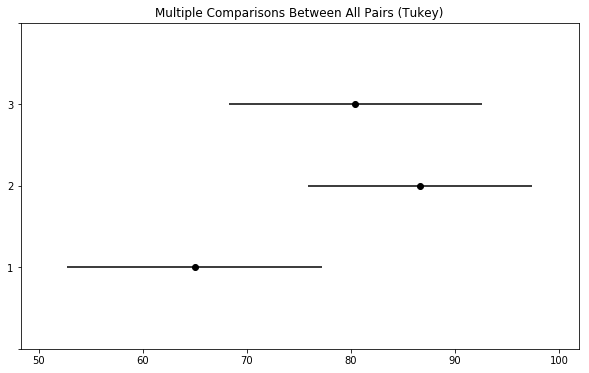

In [54]:
#pairwise tukey test
tukey_results = pairwise_tukeyhsd(q5['Freight'], q5['ShipVia'])
display(tukey_results.summary())
tukey_results.plot_simultaneous().show()

From both our ANOVA test and Tukey test, we cannot reject the null hypothesis that freight cost is significantly affected by shipping company.

## Question 6
### We will explore questions circulating around processing time (days between order being put in and order being shipped).

### Does category of product have a statistically signficiant effect on processing time? If so, which ones?

$H_0$: there is no significant difference in processing time due to category of product  
$H_\alpha$: there is a significant difference in order quantity due to category of product

In [55]:
#SQL query selecting quantity ordered and discount
x = """SELECT o.Id, od.Quantity, od.Discount, o.OrderDate, o.ShippedDate, p.CategoryId, ca.CategoryName
       FROM OrderDetail od
       JOIN [Order] AS o ON od.OrderId = o.Id
       JOIN Product AS p ON od.ProductId = p.Id
       JOIN Category AS ca ON p.CategoryId = ca.Id
       WHERE o.ShippedDate IS NOT NULL
       ;"""
q6 = pd.read_sql_query(x, conn)
q6.tail()

,Id,Quantity,Discount,OrderDate,ShippedDate,CategoryId,CategoryName
2077,11066,3,0.0,2014-05-01,2014-05-04,3,Confections
2078,11066,42,0.0,2014-05-01,2014-05-04,3,Confections
2079,11066,35,0.0,2014-05-01,2014-05-04,1,Beverages
2080,11067,9,0.0,2014-05-04,2014-05-06,8,Seafood
2081,11069,20,0.0,2014-05-04,2014-05-06,1,Beverages


In [56]:
#change column datatype
q6.OrderDate = pd.to_datetime(q6.OrderDate)
q6.ShippedDate = pd.to_datetime(q6.ShippedDate)
#loop through OrderDate column and calculate days between two dates
for idx, x in enumerate(q6.OrderDate):
    q6.loc[idx, 'Daysbeforeship'] = (q6.iloc[idx]['ShippedDate'] - q6.iloc[idx]['OrderDate']).days
q6.head()

,Id,Quantity,Discount,OrderDate,ShippedDate,CategoryId,CategoryName,Daysbeforeship
0,10248,12,0.0,2012-07-04,2012-07-16,4,Dairy Products,12.0
1,10248,10,0.0,2012-07-04,2012-07-16,5,Grains/Cereals,12.0
2,10248,5,0.0,2012-07-04,2012-07-16,4,Dairy Products,12.0
3,10249,9,0.0,2012-07-05,2012-07-10,7,Produce,5.0
4,10249,40,0.0,2012-07-05,2012-07-10,7,Produce,5.0


In [57]:
#map Quantity counts to each quantity value
z = q6['Quantity'].value_counts()
z1 = z.to_dict()
q6['Count'] = q6['Quantity'].map(z1)
#looping through Count column and dropping any values less than 4 except when Quantity equals 1
for idx, x in enumerate(q6.Count):
    if x < 4:
        if q6.Quantity[idx] == 1:
            pass
        else:
            q6.drop(index = idx, axis = 0, inplace=True)
q6 = q6.reset_index(drop=True)
q6.head()

,Id,Quantity,Discount,OrderDate,ShippedDate,CategoryId,CategoryName,Daysbeforeship,Count
0,10248,12,0.0,2012-07-04,2012-07-16,4,Dairy Products,12.0,90
1,10248,10,0.0,2012-07-04,2012-07-16,5,Grains/Cereals,12.0,174
2,10248,5,0.0,2012-07-04,2012-07-16,4,Dairy Products,12.0,67
3,10249,9,0.0,2012-07-05,2012-07-10,7,Produce,5.0,30
4,10249,40,0.0,2012-07-05,2012-07-10,7,Produce,5.0,111


,sum_sq,df,F,PR(>F)
C(CategoryId),231.434185,7.0,0.737923,0.639805
Residual,91534.919789,2043.0,NaN,NaN


group1,group2,meandiff,lower,upper,reject
1,2,0.0245,-1.7386,1.7876,False
1,3,-0.0315,-1.5683,1.5053,False
1,4,-0.4093,-1.9088,1.0903,False
1,5,-0.0952,-1.8973,1.7069,False
1,6,-0.1411,-2.0283,1.7461,False
1,7,-1.155,-3.2469,0.937,False
1,8,-0.6881,-2.2383,0.862,False
2,3,-0.056,-1.8772,1.7651,False
2,4,-0.4338,-2.2236,1.356,False
2,5,-0.1197,-2.1697,1.9303,False


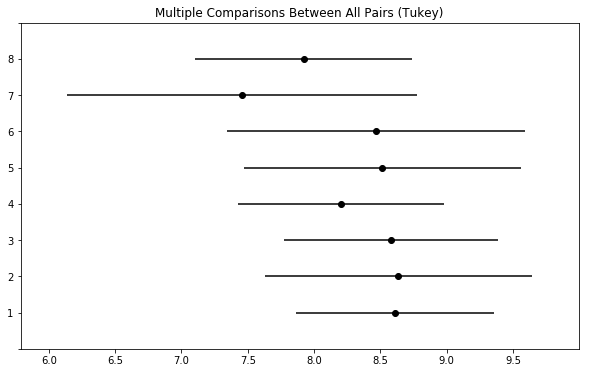

In [58]:
#onw-way ANOVA test
f = 'Daysbeforeship ~ C(CategoryId)'
lm = ols(f, q6).fit()
table = sm.stats.anova_lm(lm, typ=2)
display(table)
#pairwise tukey test
tukey_results = pairwise_tukeyhsd(q6['Daysbeforeship'], q6['CategoryId'])
display(tukey_results.summary())
tukey_results.plot_simultaneous().show()

From both our ANOVA test and Tukey test, we cannot reject the null hypothesis that category of product significantly affects processing time.

### Does having a discount on the order have a statistically significant effect on processing time?

$H_0$: there is no significant difference in processing due to discount being applied  
$H_\alpha$: there is a significant difference in processing due to discount being applied

In [59]:
#looping through Discount column and creating new column with boolean entries
for ind, x in enumerate(q6.Discount):
    if x == 0:
        q6.loc[ind, 'is_Discount'] = False
    else:
        q6.loc[ind, 'is_Discount'] = True
display(q6.sample(5))
#one-way ANOVA test
f = 'Daysbeforeship ~ C(is_Discount)'
lm = ols(f, q6).fit()
table = sm.stats.anova_lm(lm, typ=2)
display(table)
#pairwise tukey test
tukey_results = pairwise_tukeyhsd(q6['Daysbeforeship'], q6['is_Discount'])
display(tukey_results.summary())

,Id,Quantity,Discount,OrderDate,ShippedDate,CategoryId,CategoryName,Daysbeforeship,Count,is_Discount
1918,11001,25,0.00,2014-04-06,2014-04-14,5,Grains/Cereals,8.0,80,False
847,10569,35,0.20,2013-06-16,2013-07-11,4,Dairy Products,25.0,70,True
431,10412,20,0.10,2013-01-13,2013-01-15,7,Produce,2.0,243,True
726,10526,8,0.15,2013-05-05,2013-05-15,1,Beverages,10.0,48,True
1324,10756,6,0.20,2013-11-27,2013-12-02,3,Confections,5.0,87,True


,sum_sq,df,F,PR(>F)
C(is_Discount),34.637258,1.0,0.773688,0.379182
Residual,91731.716715,2049.0,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,0.2674,-0.3287,0.8635,False


From both our ANOVA test and Tukey test, we cannot reject the null hypothesis that having a discount on order significantly affects processing time.

### Does size of order have a statistically signficant effect on processing time?

$H_0$: there is no significant difference in processing time due to quantity ordered  
$H_\alpha$: there is a significant difference in processing time due to quantity ordered

,sum_sq,df,F,PR(>F)
C(CategoryQ),126.253107,6.0,0.469338,0.831459
Residual,91640.100867,2044.0,NaN,NaN


group1,group2,meandiff,lower,upper,reject
1.0,2.0,-0.0891,-1.2381,1.0599,False
1.0,3.0,0.4628,-0.8256,1.7513,False
1.0,4.0,0.2047,-1.4021,1.8116,False
1.0,5.0,-0.2872,-2.2456,1.6712,False
1.0,6.0,-0.568,-3.1376,2.0016,False
1.0,7.0,-0.0199,-2.5389,2.4992,False
2.0,3.0,0.5519,-0.716,1.8199,False
2.0,4.0,0.2938,-1.2966,1.8843,False
2.0,5.0,-0.1981,-2.1431,1.7469,False
2.0,6.0,-0.4789,-3.0383,2.0805,False


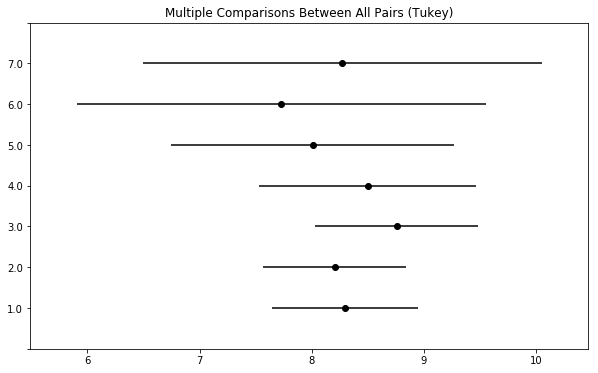

In [60]:
#looping through Quantity and creating bins
for idx, x in enumerate(q6.Quantity):
    if 0 < x <= 10:
        q6.loc[idx, 'CategoryQ'] = 1
    elif 10 < x <= 20:
        q6.loc[idx, 'CategoryQ'] = 2
    elif 20 < x <= 30:
        q6.loc[idx, 'CategoryQ'] = 3
    elif 30 < x <= 40:
        q6.loc[idx, 'CategoryQ'] = 4
    elif 40 < x <= 50:
        q6.loc[idx, 'CategoryQ'] = 5
    elif 50 < x <= 60:
        q6.loc[idx, 'CategoryQ'] = 6
    elif 60 < x :
        q6.loc[idx, 'CategoryQ'] = 7
#one-way ANOVA test
f = 'Daysbeforeship ~ C(CategoryQ)'
lm = ols(f, q6).fit()
table = sm.stats.anova_lm(lm, typ=2)
display(table)
#pairwise tukey test
tukey_results = pairwise_tukeyhsd(q6['Daysbeforeship'], q6['CategoryQ'])
display(tukey_results.summary())
tukey_results.plot_simultaneous().show()

From both our ANOVA test and Tukey test, we cannot reject the null hypothesis that quantity ordered significantly affects processing time.

### Does shipping company have a statistically significant effect on processing time?

$H_0$: there is no significant difference in processing time due to shipper  
$H_\alpha$: there is a significant difference in processing time due to shipper

,Daysbeforeship
ShipVia,
1,8.571429
2,9.234921
3,7.473896


,sum_sq,df,F,PR(>F)
C(ShipVia),433.501581,2.0,4.676819,0.009563
Residual,37354.696194,806.0,NaN,NaN


group1,group2,meandiff,lower,upper,reject
1,2,0.6635,-0.6982,2.0252,False
1,3,-1.0975,-2.536,0.3409,False
2,3,-1.761,-3.1165,-0.4055,True


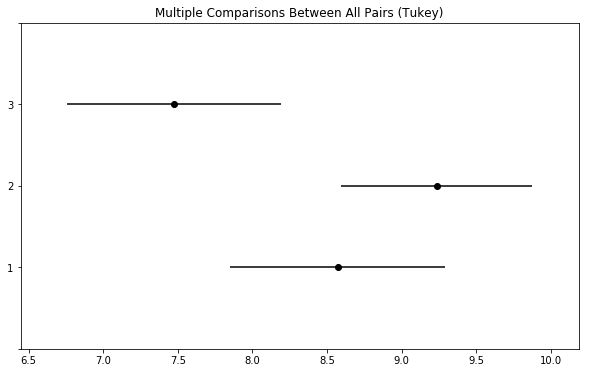

In [61]:
#SQL query selecting quantity ordered and discount
x = """SELECT Id, OrderDate, ShippedDate, ShipVia
       FROM [Order]
       WHERE ShippedDate IS NOT NULL
       ;"""
q6A = pd.read_sql_query(x, conn)
q6A.tail()

#change column datatype
q6A.OrderDate = pd.to_datetime(q6A.OrderDate)
q6A.ShippedDate = pd.to_datetime(q6A.ShippedDate)
#loop through OrderDate column and calculate days between two dates
for idx, x in enumerate(q6A.OrderDate):
    q6A.loc[idx, 'Daysbeforeship'] = (q6A.iloc[idx]['ShippedDate'] - q6A.iloc[idx]['OrderDate']).days

#drop duplicate rows
q6B = q6A.drop_duplicates(subset=None, keep='first')
q6B.drop(['Id'], axis = 1, inplace = True)
q6B = q6B.reset_index(drop=True)
#groupby function by ShipVia
display(q6B.groupby('ShipVia').mean())
#one-way ANOVA test
f = 'Daysbeforeship ~ C(ShipVia)'
lm = ols(f, q6B).fit()
table = sm.stats.anova_lm(lm, typ=2)
display(table)
#pairwise tukey test
tukey_results = pairwise_tukeyhsd(q6B['Daysbeforeship'], q6B['ShipVia'])
display(tukey_results.summary())
tukey_results.plot_simultaneous().show()

In [62]:
#new dataframes where ShipVia is specific value only
q61 = q6B.loc[q6B['ShipVia'] == 1]
q62 = q6B.loc[q6B['ShipVia'] == 2]
q63 = q6B.loc[q6B['ShipVia'] == 3]
#run cohen's d function
print(cohens_d(q61['Daysbeforeship'], q62['Daysbeforeship']))
print(cohens_d(q61['Daysbeforeship'], q63['Daysbeforeship']))
print(cohens_d(q62['Daysbeforeship'], q63['Daysbeforeship']))

0.09148299737261549
0.17564439393687006
0.25819634131476343


After testing the effect of shipping company on processing time (time between order date and shipping date), we find that our ANOVA test states we should reject our null hypothesis of no significance and out tukey test confirms that for the relationship between shipping companies 3 and 2 only. Our tukey test states that company 3 has a significant difference in mean of -1.76 days of processing time over 2. Our effect sizes for the three relationships also confirm that only 2 and 3 have a relationship that is not trivial.

In [63]:
#SQL query selecting quantity ordered and discount
x = """SELECT Id, CompanyName
       FROM Shipper
       ;"""
q7 = pd.read_sql_query(x, conn)
#drop duplicate rows
q7.drop_duplicates(subset=None, keep='first')

,Id,CompanyName
0,1,Speedy Express
1,2,United Package
2,3,Federal Shipping


In [64]:
#SQL query selecting quantity ordered and discount
x = """SELECT o.ShipVia, o.Freight, od.UnitPrice, od.Quantity, od.Discount
       FROM [Order] as o
       JOIN Orderdetail AS od ON o.Id = od.OrderId
       ;"""
q7A = pd.read_sql_query(x, conn)
q7A.sample(5)

,ShipVia,Freight,UnitPrice,Quantity,Discount
1548,3,35.43,34.8,15,0.10
369,2,93.63,44.0,12,0.00
1630,1,143.28,21.0,10,0.00
1308,3,31.43,6.0,6,0.00
765,2,58.88,38.0,15,0.25


In [65]:
#create new column with profit values as entries
q7A['Profit'] = (q7A.UnitPrice*q7A.Quantity*(1-q7A.Discount)) - q7A.Freight
q7A.sample(5)

,ShipVia,Freight,UnitPrice,Quantity,Discount,Profit
2029,3,84.74,32.8,70,0.1,1981.66
1520,2,72.19,9.2,2,0.0,-53.79
766,2,58.88,12.5,20,0.0,191.12
1213,2,2.96,19.0,5,0.0,92.04
551,2,180.45,22.8,25,0.0,389.55


In [66]:
#groupby function by ShipVia
q7A.groupby('ShipVia').mean()

,Freight,UnitPrice,Quantity,Discount,Profit
ShipVia,,,,,
1,80.946053,24.454768,24.642415,0.061300,459.053851
2,105.983576,27.883542,23.084491,0.054965,511.548407
3,98.364558,25.754651,23.958140,0.052636,496.062524


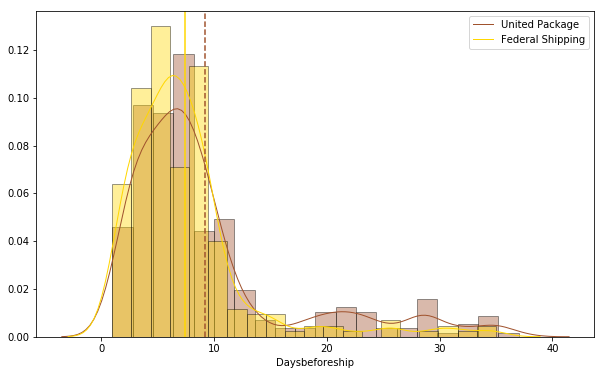

In [67]:
#set fig size
plt.figure(figsize=(10,6))
#seaborn distribution plot with arguments
sns.distplot(q62['Daysbeforeship'], hist=True, kde=True, 
             bins=int(20), color = 'sienna', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1, 'label': 'United Package'})
#seaborn distribution plot with arguments
sns.distplot(q63['Daysbeforeship'], hist=True, kde=True, 
             bins=int(20), color = 'gold', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1, 'label': 'Federal Shipping'})
#set both mean lines
plt.axvline(x=q62['Daysbeforeship'].mean(), color='sienna', linestyle='--')
plt.axvline(x=q63['Daysbeforeship'].mean(), color='gold', linestyle='-')
#save figure as png
plt.savefig('ShipProcessingTimeDensity.png')

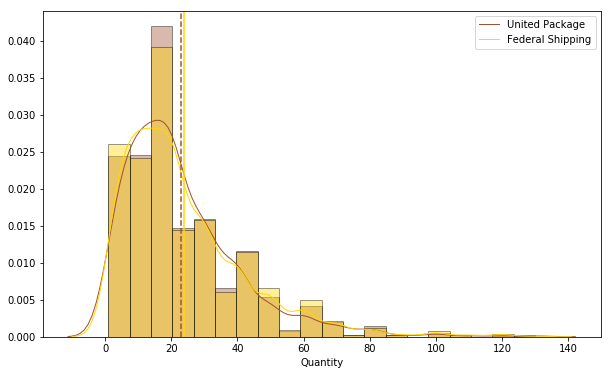

In [68]:
#new dataframes where ShipVia is specific value only
q7A2= q7A.loc[q7A['ShipVia'] == 2]
q7A3 = q7A.loc[q7A['ShipVia'] != 3]
#set fig size
plt.figure(figsize=(10,6))
#seaborn distribution plot with arguments
sns.distplot(q7A2['Quantity'], hist=True, kde=True, 
             bins=int(20), color = 'sienna', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1, 'label': 'United Package'})
#seaborn distribution plot with arguments
sns.distplot(q7A3['Quantity'], hist=True, kde=True, 
             bins=int(20), color = 'gold', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1, 'label': 'Federal Shipping'})
#set both mean lines
plt.axvline(x=q7A2['Quantity'].mean(), color='sienna', linestyle='--')
plt.axvline(x=q7A3['Quantity'].mean(), color='gold', linestyle='-')
#save figure as png
plt.savefig('ShipQuantityDensity.png')

Although, we know that Federal Shipping has a significantly less processing time than United Package, Northwind makes more profit on average using United Package rather than Federal Shipping. This is unusual as United Package also charges the largest freight cost, therefore, there must be other factors influencing profit such as Unit Price. In our two density graphs, we may observe that more orders of the same quantities than federal shipping does, whereas Federal shipping has more orders with less processing time than United Package does.

## Results
##### Question 1
Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount? **Reject Null Hypothesis and levels 0.01-0.06 and 0.15 are the best.**  
##### Question 2
Is there a statistically significant difference in the level(s) of discount offered by UK employees and USA employees?  **Reject Null Hypothesis**  
Does the level(s) of discount offered by US employees have a statistically significant effect on the quantity ordered? If so, at what level(s) of discount?  **Reject Null Hypothesis and levels 0.01-0.06 and 0.15 are the best.**  
Does the level(s) of discount offered by UK employees have a statistically significant effect on the quantity ordered? If so, at what level(s) of discount? **Reject Null Hypothesis and level 0.25 is the best.**    
##### Question 3
Does the age of the employee have a statistically significant effect on number of orders processed? **Cannot reject Null Hypothesis.**  
Does having a managerial position in Northwind have a statistically significant effect on number of orders recieved? **Cannot reject Null Hypothesis.**  
Does the age of the employee have a statistically significant effect on the quantity of a product in an order? **Cannot reject Null Hypothesis.**  
Does having manager in your title have a statistically significant effect on quantity ordered by the customer? **Reject Null Hypothesis and 4.83 greater difference in mean when customers' employees making the order have a managerial position.**  
##### Question 4
For each category type of product, does the season in which the order was placed have a statistically significant effect on the quantity of a product in an order? **Reject Null Hypothesis for Dairy Products in Winter: +4.99 units, Seafood in Spring: -4.95 units, Condiments in Winter: +6.97 units, and Condiments in Spring: -5.83 units.**  
##### Question 5
Does shipping company used have a statistically significant effect on the freight cost of shipping? **Cannot reject Null Hypothesis.**   
##### Question 6
Does category of product have a statistically signficiant effect on processing time? If so, which ones? **Cannot reject Null Hypothesis.**  
Does having a discount on the order have a statistically significant effect on processing time? **Cannot reject Null Hypothesis.**   
Does size of order have a statistically signficant effect on processing time? **Cannot reject Null Hypothesis.**  
Does shipping company have a statistically significant effect on processing time? **Reject Null Hypothesis for difference between Shipping Company 2 (United Package) and 3 (Federal Shipping) with a mean difference of -1.76 days in favor of United Package. United Package has a greater average freight cost however.**

## Further Steps

$-$ Further investigate if lowering discount level below suggested 15% is better  
$-$ Find out optimal levels of discount for each product for their seasonal demand (if that exists)  
$-$ Explore where to lower costs whether in employee demmographic or shipping  